<a href="https://colab.research.google.com/github/stanleydukor/Anaconda/blob/master/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Mortgage Approvals From Government Data
## Executive Summary
The culminating task for the Microsoft Professional Program in Data Science was to use data adapted from the Federal Financial Institutions Examination Council's (FFIEC) to build a machine learning model able to predict whether a mortgage application was accepted or denied.

This report will review data exploration that was done to examine the relationship between features that were available in the data using descriptive statstics and data visualization. These finding lead us to know what to exclude from the model as well as suggested what would likely help us predict whether a mortgage application was accepted or denied.

The best model was able to achieve a classification rate of 0.7155 on the test set hosted on DrivenData, and was an ensemble of four classification models, XGBoost, Gradient Boost, Adaboost and Random Forest classifiers.

## Exploring the Available Data
The entire game of modeling is based on the idea that there is information hidden in our data, and that these patterns can be figured out. However when we are given a number of different variables, a first important task is get a sense of which variables might have the most information about how to distinguish between the target classes. To this end data visualization is a very helpful tool in identifying which variables have the most visible trends with our target.

In [0]:
# These are our main data structures
import pandas as pd 
import numpy as np                     # For mathematical calculations 
import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings warnings.filterwarnings("ignore")

In [0]:
# Import csv files and load into pandas dataframe
train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values = pd.read_csv("test_values.csv")
submission_format = pd.read_csv("submission_format.csv")

With the data loaded, we can view some quick and basic information about out data

In [0]:
train_values.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant
0,0,3,1,1,1,70.0,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False
1,1,1,1,3,1,178.0,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False
2,2,2,1,3,1,163.0,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False
3,3,1,1,1,1,155.0,1,305,47,180,2,5,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True
4,4,1,1,1,1,305.0,3,24,37,20,2,3,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False


In [0]:
print(f"The training data set has {train_values.shape[0]} records and {train_values.shape[1]} columns")
print("Descriptive stats are easily available for numeric variables.")
train_values.describe().T

The training data set has 500000 records and 22 columns
Descriptive stats are easily available for numeric variables.


,count,mean,std,min,25%,50%,75%,max
row_id,500000.0,249999.500000,144337.711634,0.000,124999.75000,249999.500,374999.25,499999.0
loan_type,500000.0,1.366276,0.690555,1.000,1.00000,1.000,2.00,4.0
property_type,500000.0,1.047650,0.231404,1.000,1.00000,1.000,1.00,3.0
loan_purpose,500000.0,2.066810,0.948371,1.000,1.00000,2.000,3.00,3.0
occupancy,500000.0,1.109590,0.326092,1.000,1.00000,1.000,1.00,3.0
loan_amount,500000.0,221.753158,590.641648,1.000,93.00000,162.000,266.00,100878.0
preapproval,500000.0,2.764722,0.543061,1.000,3.00000,3.000,3.00,3.0
msa_md,500000.0,181.606972,138.464169,-1.000,25.00000,192.000,314.00,408.0
state_code,500000.0,23.726924,15.982768,-1.000,6.00000,26.000,37.00,52.0
county_code,500000.0,144.542062,100.243612,-1.000,57.00000,131.000,246.00,324.0


In [0]:
train_labels.head()

,row_id,accepted
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


## Data Exploration

These explorations and analysis show how the answers to Challenge 1 were gotten.

In [0]:
train_values.loan_amount.std()

590.6416481879309

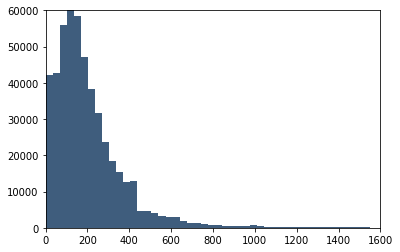

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

vals = np.size(train_values['loan_amount'].unique()) # to determine the numberof bins
plt.hist(train_values['loan_amount'], bins=vals, color='#3F5D7D')
axes = plt.gca()
axes.set_xlim([0,1600])
axes.set_ylim([0,60000])
plt.show()

In [0]:
len(train_values)

500000

In [0]:
train = pd.merge(train_values, train_labels, on='row_id')
train.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0,3,1,1,1,70.0,3,18,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False,1
1,1,1,1,3,1,178.0,3,369,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False,0
2,2,2,1,3,1,163.0,3,16,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False,1
3,3,1,1,1,1,155.0,1,305,47,180,2,5,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True,1
4,4,1,1,1,1,305.0,3,24,37,20,2,3,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False,1


In [0]:
train.groupby('applicant_sex')['accepted'].mean()

applicant_sex
1    0.520823
2    0.466453
3    0.406054
4    0.795947
Name: accepted, dtype: float64

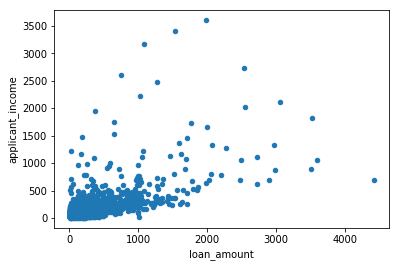

In [0]:
test = train[train.state_code == 45]
test.plot(kind='scatter', x='loan_amount', y='applicant_income')

In [0]:
test = train[train.state_code == 48]
test = test[test.county_code != -1]
test.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
27,27,1,1,2,1,15.0,3,254,48,56,2,5,1,53.0,4885.0,2.693,62795.0,100.000,1462.0,1955.0,4419,True,1
104,104,1,1,3,1,361.0,3,314,48,321,1,5,2,81.0,8066.0,96.815,70626.0,46.626,203.0,341.0,3507,False,0
105,105,1,1,1,1,423.0,3,92,48,61,2,5,2,NaN,8946.0,6.166,82440.0,100.000,2534.0,3100.0,2275,True,1
157,157,1,1,2,1,8.0,3,314,48,246,2,5,1,42.0,2003.0,22.495,70713.0,70.205,493.0,760.0,2769,False,0
272,272,1,1,3,1,50.0,3,145,48,136,2,5,1,134.0,3911.0,4.194,58823.0,100.000,1455.0,4030.0,879,True,1


In [0]:
test.groupby('county_code')['accepted'].mean().max()

0.6666666666666666

In [0]:
test.groupby('county_code')['accepted'].mean().min()

0.3150684931506849

In [0]:
test = train[((train.state_code == 2) | (train.state_code == 4))]
test.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
14,14,1,1,1,2,151.0,3,281,2,210,2,5,1,172.0,2165.0,3.916,63560.0,100.000,839.0,1263.0,5473,True,0
20,20,1,1,3,1,111.0,3,278,2,208,1,5,2,41.0,6059.0,96.448,50655.0,72.441,1325.0,1551.0,5726,True,0
52,52,1,1,1,1,88.0,2,80,2,134,2,5,2,50.0,3023.0,27.691,66520.0,100.000,1106.0,1251.0,4750,False,1
54,54,1,1,1,1,304.0,2,286,4,321,2,5,1,168.0,5459.0,8.739,88608.0,100.000,1689.0,1992.0,3231,True,0
60,60,1,1,3,1,185.0,3,311,2,68,3,5,1,43.0,4139.0,8.278,62864.0,100.000,1280.0,1537.0,4988,False,0


In [0]:
# overall loan acceptance rate for both 2 and 4
test.accepted.mean()

0.4903343840236295

In [0]:
# loan acceptance rate for both 2 and 4
test.groupby('loan_type')['accepted'].mean()

loan_type
1    0.474463
2    0.516159
3    0.564725
4    0.515228
Name: accepted, dtype: float64

In [0]:
# loan acceptance rate for 2
train[train.state_code == 2].groupby('loan_type')['accepted'].mean()

loan_type
1    0.435804
2    0.503708
3    0.531802
4    0.461240
Name: accepted, dtype: float64

In [0]:
# loan acceptance rate for 4
train[train.state_code == 4].groupby('loan_type')['accepted'].mean()

loan_type
1    0.569992
2    0.554178
3    0.639456
4    0.617647
Name: accepted, dtype: float64

## Drop unneccessary columns

In [0]:
train_values.drop(['lender', 'msa_md'],axis=1, inplace=True)
test_values.drop(['lender', 'msa_md'],axis=1, inplace=True)

In [0]:
# Combine train and test so as to perform feature engineering on both datasets
train_values['sep']='Train'
test_values['sep']='Test'
data = pd.concat([train_values,test_values], sort=False)
data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,co_applicant,sep
0,0,3,1,1,1,70.0,3,37,246,2,5,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,False,Train
1,1,1,1,3,1,178.0,3,52,299,1,5,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,False,Train
2,2,2,1,3,1,163.0,3,10,306,2,5,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,False,Train
3,3,1,1,1,1,155.0,1,47,180,2,5,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,True,Train
4,4,1,1,1,1,305.0,3,37,20,2,3,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,False,Train


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 499999
Data columns (total 21 columns):
row_id                            1000000 non-null int64
loan_type                         1000000 non-null int64
property_type                     1000000 non-null int64
loan_purpose                      1000000 non-null int64
occupancy                         1000000 non-null int64
loan_amount                       1000000 non-null float64
preapproval                       1000000 non-null int64
state_code                        1000000 non-null int64
county_code                       1000000 non-null int64
applicant_ethnicity               1000000 non-null int64
applicant_race                    1000000 non-null int64
applicant_sex                     1000000 non-null int64
applicant_income                  919911 non-null float64
population                        955055 non-null float64
minority_population_pct           955052 non-null float64
ffiecmedian_family_income   

## Exploring the Distribution of Each Variable (Univariate Analysis)

It can be extremely valuable to study the distributions of each variable and compare pairs of variables. This practice can help us identify which features are sneaking the most noise into our model, and how variables are effecting each other in isolation. Through visualization or some calculation, we explore each of the following questions:

What are the distributions of each variable?
How are the feature correllated with each other?
How are the features correllated with the response variable?
What are the distributions of each variable?
To visualize the distributions of each variable in our dataset, we have created the histograms and bar plots below.

### Target Variable

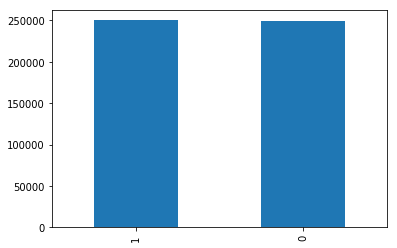

In [0]:
train_labels['accepted'].value_counts().plot.bar()

### Categorical Variables (Nominal)

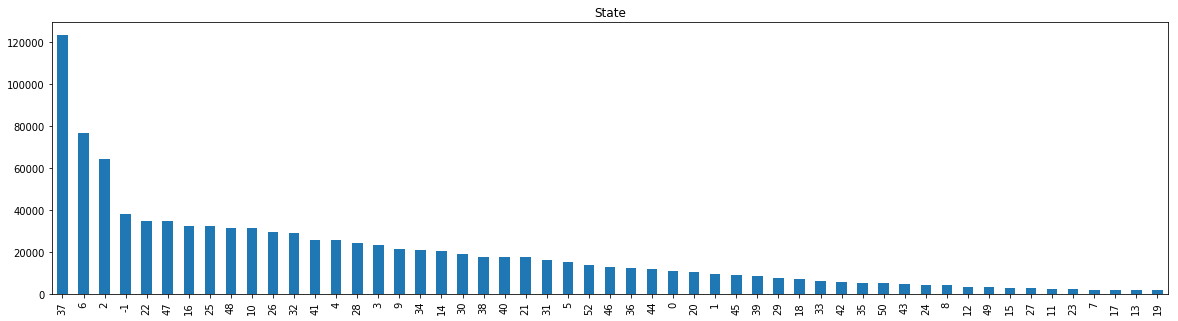

In [0]:
plt.figure(1, figsize=(20, 5))
data['state_code'].value_counts().plot.bar(title= 'State')
plt.show()

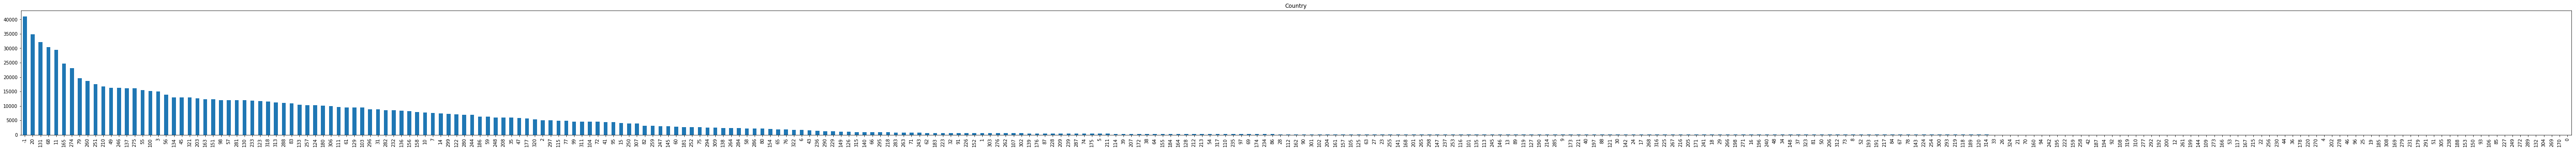

In [0]:
plt.figure(1, figsize=(100, 5))
data['county_code'].value_counts().plot.bar(title= 'Country')
plt.show()

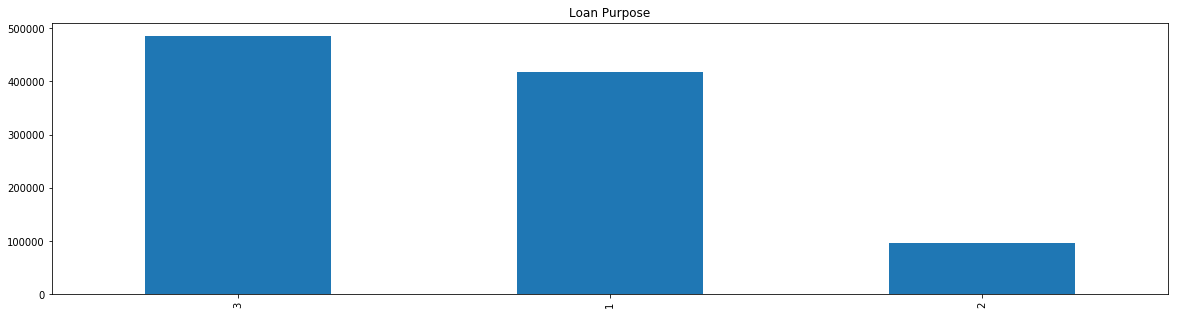

In [0]:
plt.figure(1, figsize=(20, 5))
data['loan_purpose'].value_counts().plot.bar(title= 'Loan Purpose')
plt.show()

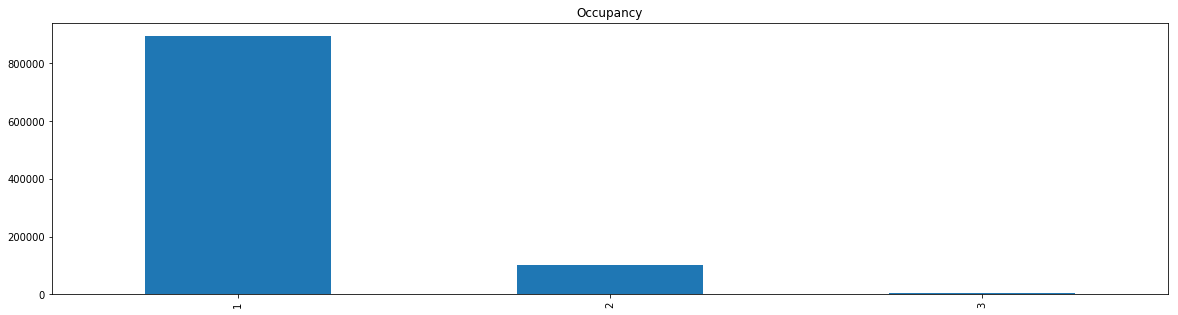

In [0]:
plt.figure(1, figsize=(20, 5))
data['occupancy'].value_counts().plot.bar(title= 'Occupancy')
plt.show()

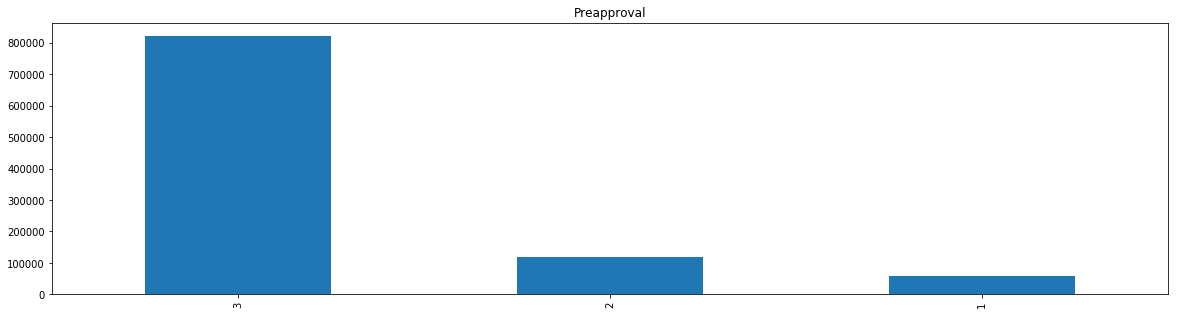

In [0]:
plt.figure(1, figsize=(20, 5))
data['preapproval'].value_counts().plot.bar(title= 'Preapproval')
plt.show()

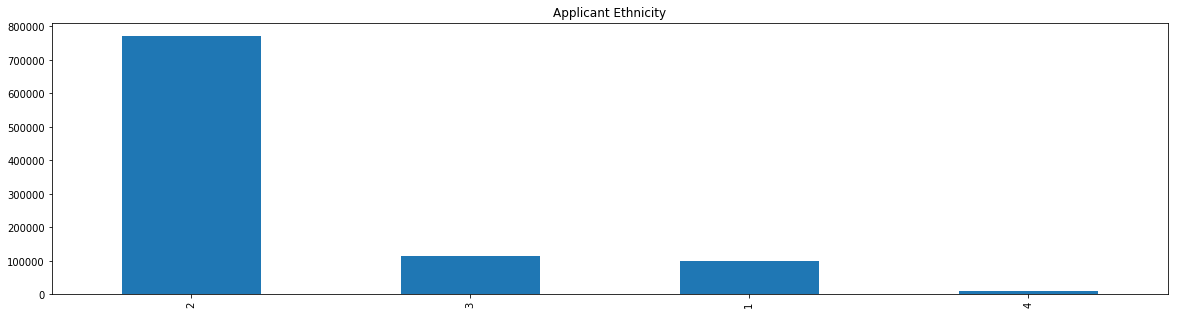

In [0]:
plt.figure(1, figsize=(20, 5))
data['applicant_ethnicity'].value_counts().plot.bar(title= 'Applicant Ethnicity')
plt.show()

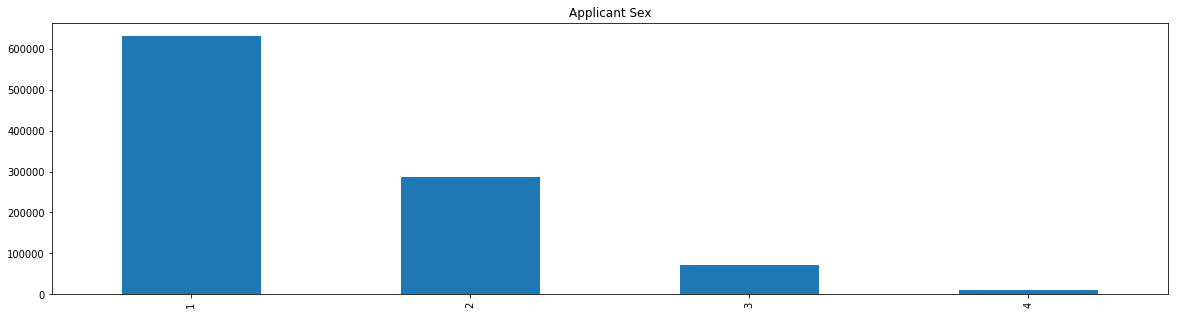

In [0]:
plt.figure(1, figsize=(20, 5))
data['applicant_sex'].value_counts().plot.bar(title= 'Applicant Sex')
plt.show()

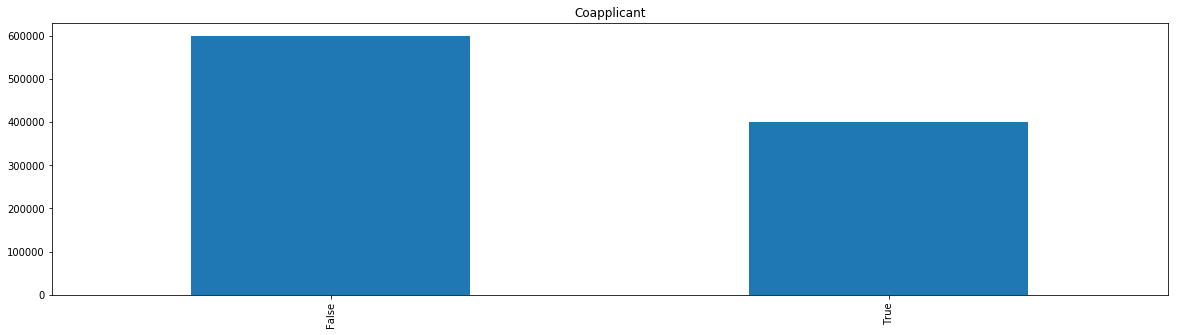

In [0]:
plt.figure(1, figsize=(20, 5))
data['co_applicant'].value_counts().plot.bar(title= 'Coapplicant')
plt.show()

### Categorical Variables (Ordinal)

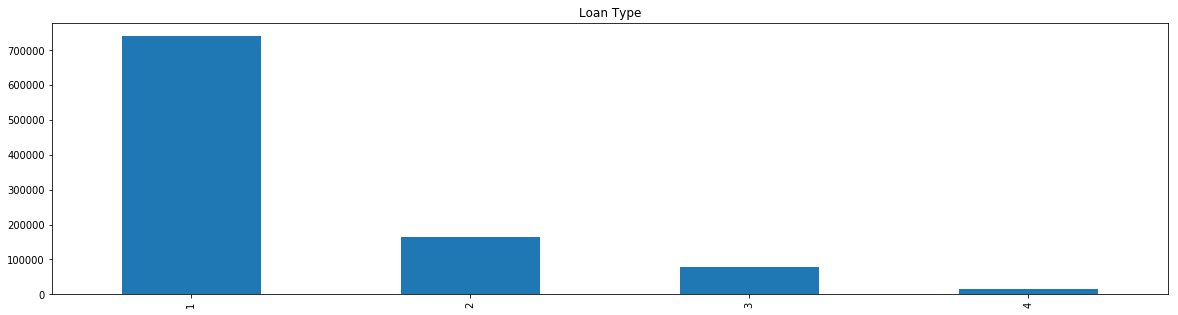

In [0]:
plt.figure(1, figsize=(20, 5))
data['loan_type'].value_counts().plot.bar(title= 'Loan Type')
plt.show()

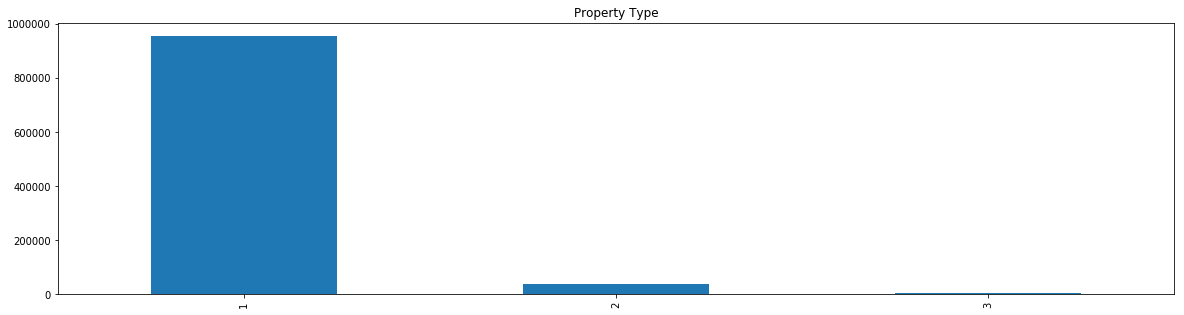

In [0]:
plt.figure(1, figsize=(20, 5))
data['property_type'].value_counts().plot.bar(title= 'Property Type')
plt.show()

### Numerical Variables

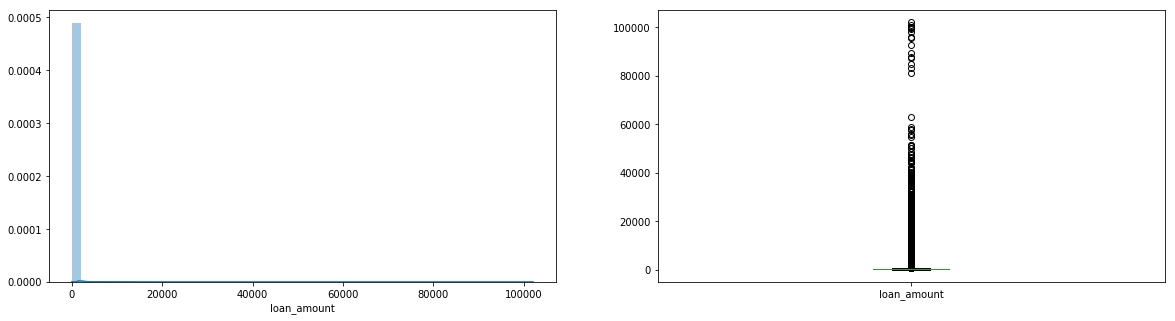

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data['loan_amount']); 
plt.subplot(122) 
data['loan_amount'].plot.box(figsize=(20,5)) 
plt.show()

Text(0.5, 0.98, '')

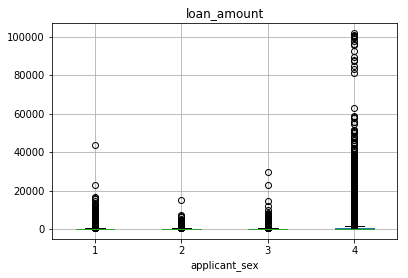

In [0]:
data.boxplot(column='loan_amount', by = 'applicant_sex') 
plt.suptitle("")

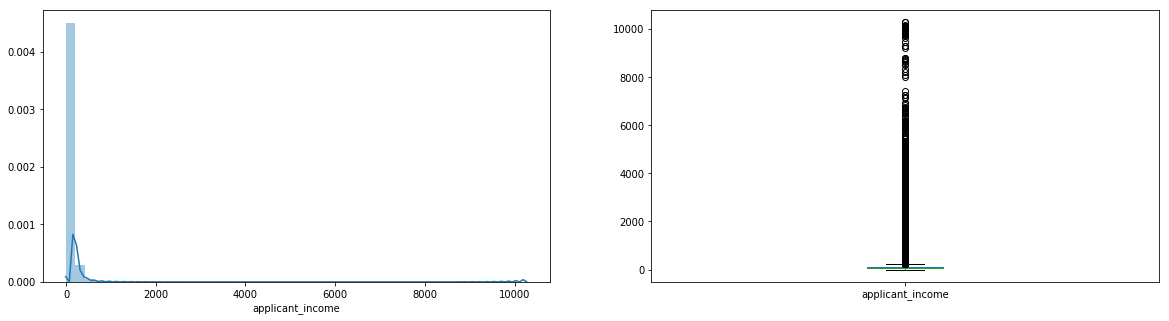

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['applicant_income'].notnull()]['applicant_income']); 
plt.subplot(122) 
data[data['applicant_income'].notnull()]['applicant_income'].plot.box(figsize=(20,5)) 
plt.show()

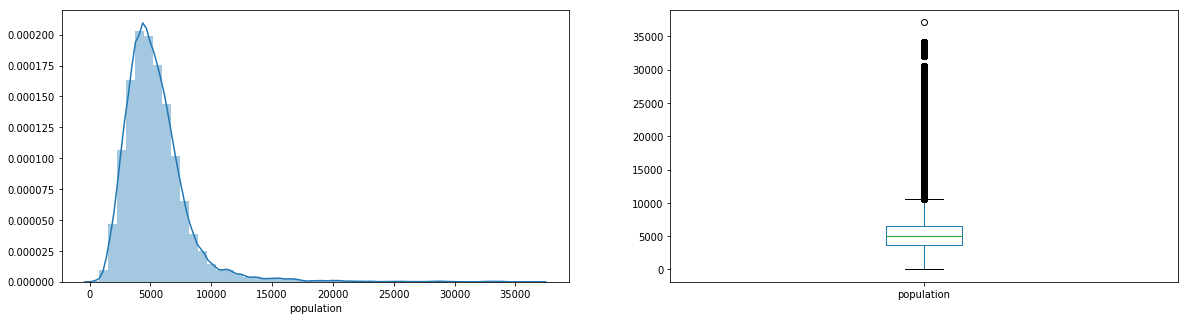

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['population'].notnull()]['population']); 
plt.subplot(122) 
data[data['population'].notnull()]['population'].plot.box(figsize=(20,5)) 
plt.show()

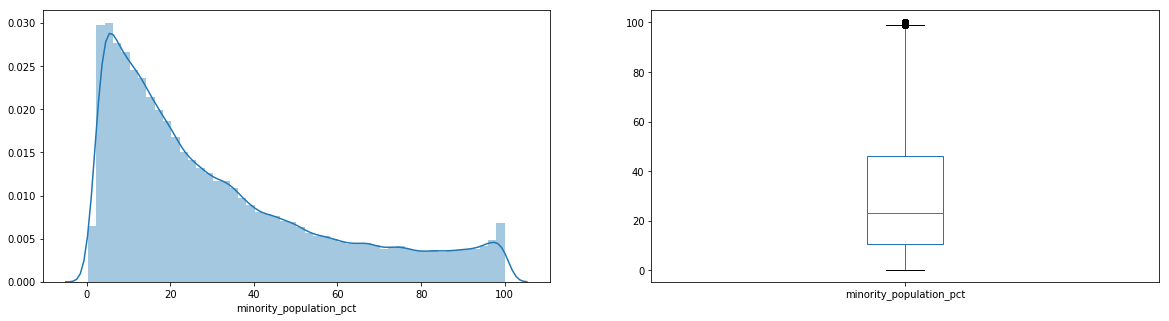

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['minority_population_pct'].notnull()]['minority_population_pct']);
plt.subplot(122) 
data[data['minority_population_pct'].notnull()]['minority_population_pct'].plot.box(figsize=(20,5)) 
plt.show()

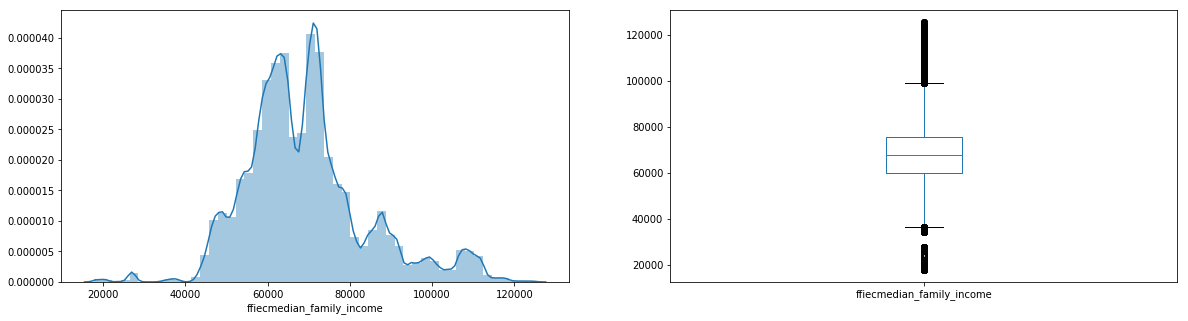

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['ffiecmedian_family_income'].notnull()]['ffiecmedian_family_income']); 
plt.subplot(122) 
data[data['ffiecmedian_family_income'].notnull()]['ffiecmedian_family_income'].plot.box(figsize=(20,5)) 
plt.show()

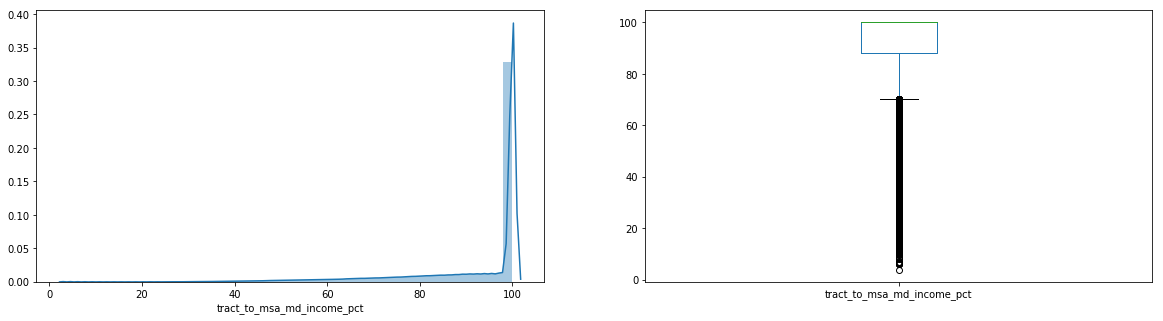

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['tract_to_msa_md_income_pct'].notnull()]['tract_to_msa_md_income_pct']);
plt.subplot(122) 
data[data['tract_to_msa_md_income_pct'].notnull()]['tract_to_msa_md_income_pct'].plot.box(figsize=(20,5)) 
plt.show()

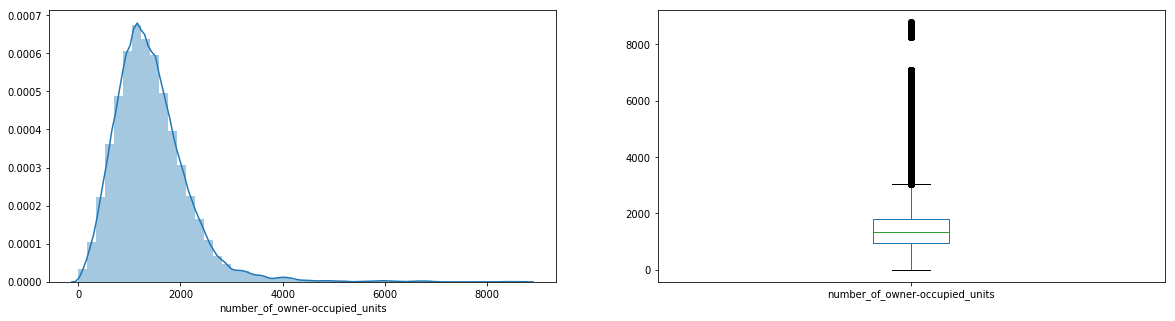

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['number_of_owner-occupied_units'].notnull()]['number_of_owner-occupied_units']); 
plt.subplot(122) 
data[data['number_of_owner-occupied_units'].notnull()]['number_of_owner-occupied_units'].plot.box(figsize=(20,5)) 
plt.show()

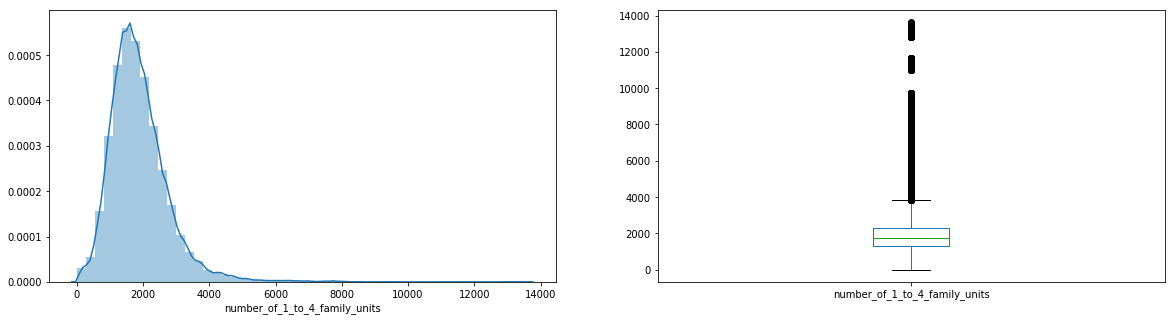

In [0]:
plt.figure(1) 
plt.subplot(121) 
sns.distplot(data[data['number_of_1_to_4_family_units'].notnull()]['number_of_1_to_4_family_units']); 
plt.subplot(122) 
data[data['number_of_1_to_4_family_units'].notnull()]['number_of_1_to_4_family_units'].plot.box(figsize=(20,5)) 
plt.show()

## Exploring how Features Correllate with each other (Bivariate Analysis)

Bi-variate Analysis finds out the relationship between two variables. Here, we look for association and disassociation between variables at a pre-defined significance level. We can perform bi-variate analysis for any combination of categorical and continuous variables.

### Categorical Independent Variable vs Target Variable

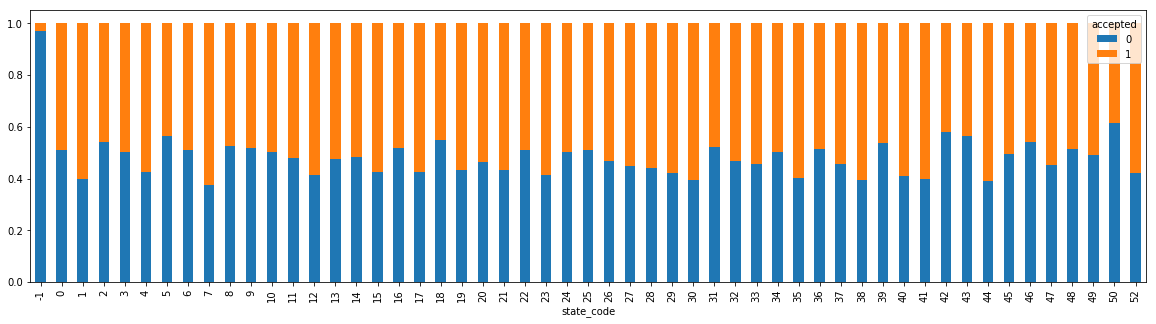

In [0]:
state_code=pd.crosstab(data[data["sep"] == "Train"]['state_code'],train_labels['accepted']) 
state_code.div(state_code.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

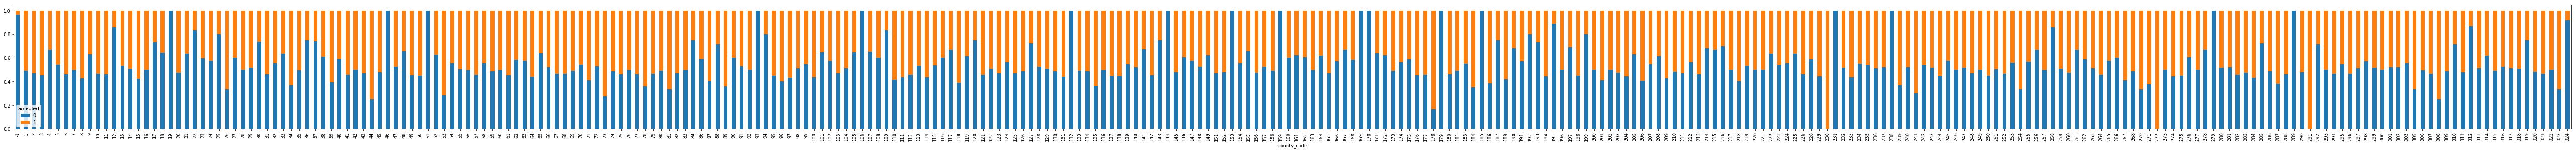

In [0]:
county_code=pd.crosstab(data[data["sep"] == "Train"]['county_code'],train_labels['accepted']) 
county_code.div(county_code.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(100,5))

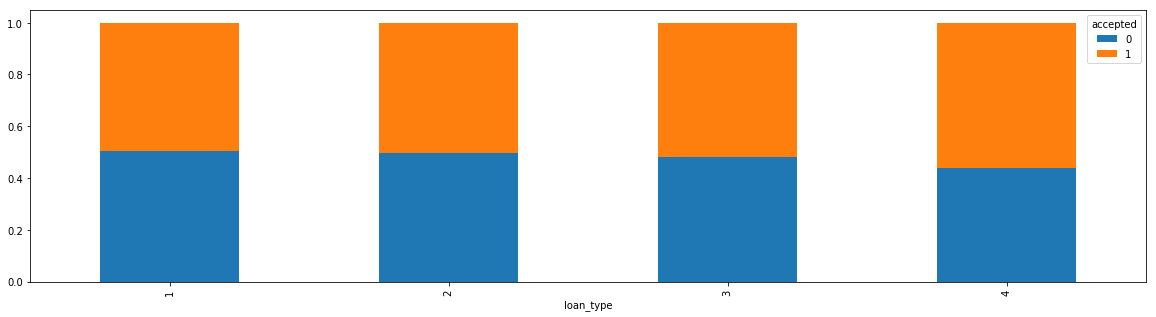

In [0]:
loan_type=pd.crosstab(data[data["sep"] == "Train"]['loan_type'],train_labels['accepted']) 
loan_type.div(loan_type.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

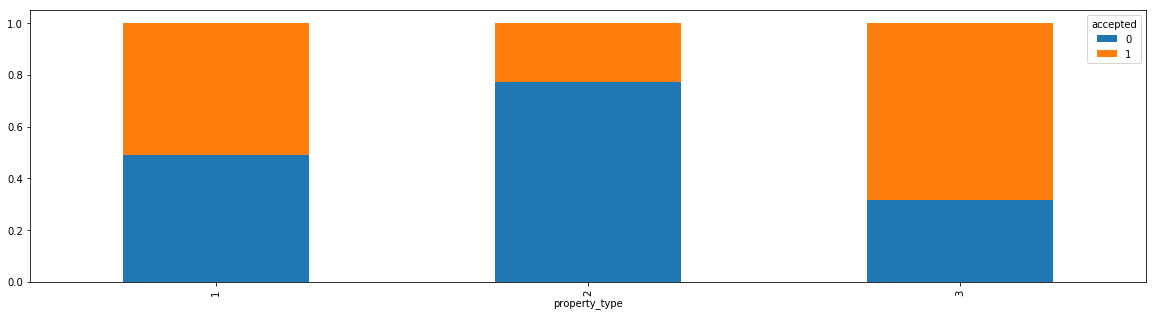

In [0]:
property_type=pd.crosstab(data[data["sep"] == "Train"]['property_type'],train_labels['accepted']) 
property_type.div(property_type.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

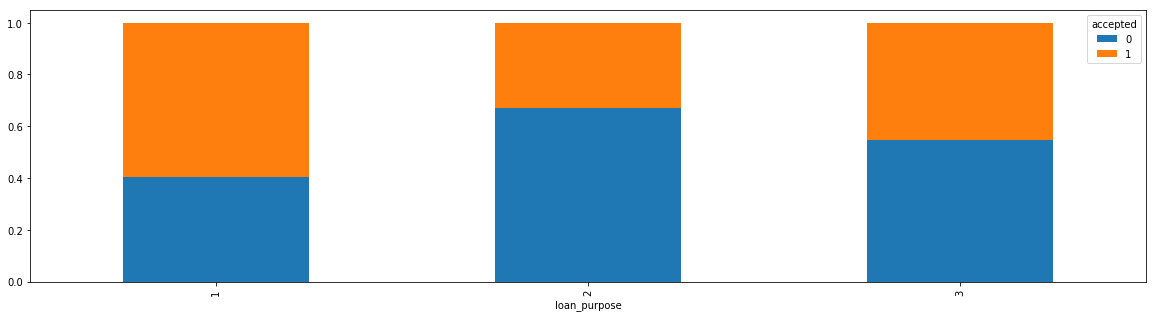

In [0]:
loan_purpose=pd.crosstab(data[data["sep"] == "Train"]['loan_purpose'],train_labels['accepted']) 
loan_purpose.div(loan_purpose.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

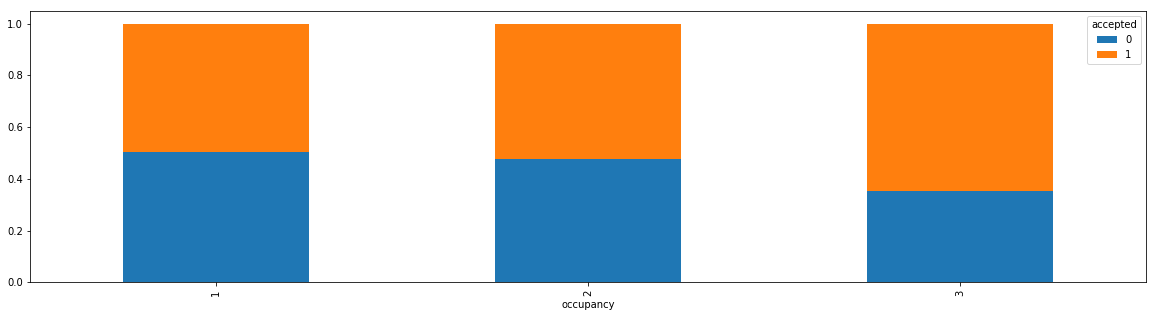

In [0]:
occupancy=pd.crosstab(data[data["sep"] == "Train"]['occupancy'],train_labels['accepted']) 
occupancy.div(occupancy.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

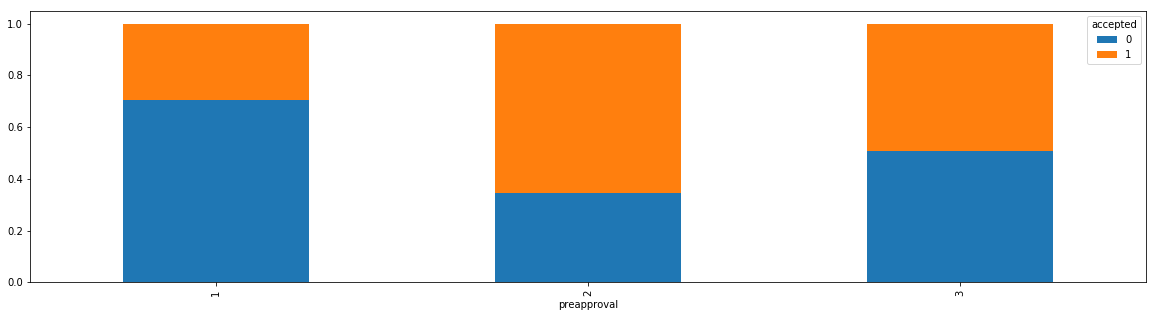

In [0]:
preapproval=pd.crosstab(data[data["sep"] == "Train"]['preapproval'],train_labels['accepted']) 
preapproval.div(preapproval.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

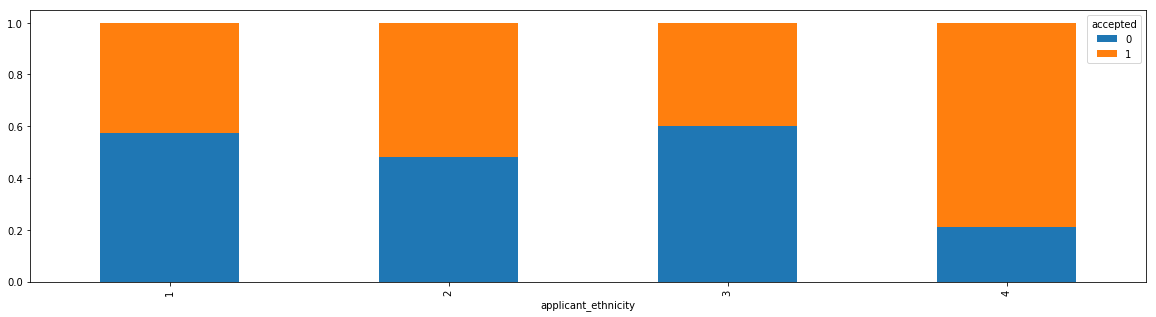

In [0]:
applicant_ethnicity=pd.crosstab(data[data["sep"] == "Train"]['applicant_ethnicity'],train_labels['accepted']) 
applicant_ethnicity.div(applicant_ethnicity.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

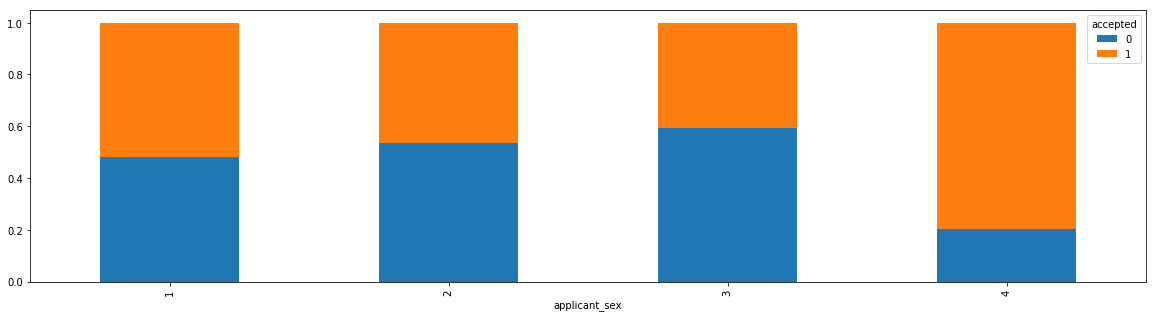

In [0]:
applicant_sex=pd.crosstab(data[data["sep"] == "Train"]['applicant_sex'],train_labels['accepted']) 
applicant_sex.div(applicant_sex.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

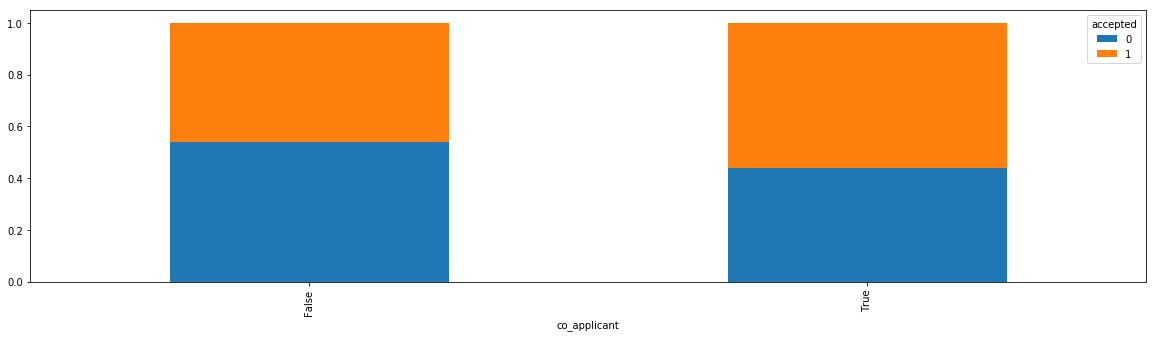

In [0]:
co_applicant=pd.crosstab(data[data["sep"] == "Train"]['co_applicant'],train_labels['accepted']) 
co_applicant.div(co_applicant.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5))

### Numerical Independent Variable vs Target Variable

In [0]:
data_plot = pd.merge(data[data["sep"] == "Train"], train_labels, on='row_id')

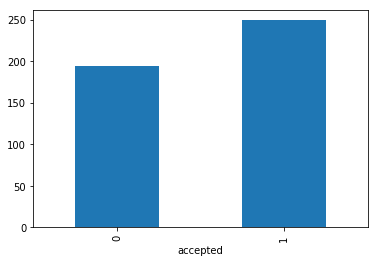

In [0]:
# mean loan amount for which the loan has been approved vs the mean loan amount for which the loan has not been approved
data_plot.groupby('accepted')['loan_amount'].mean().plot.bar()

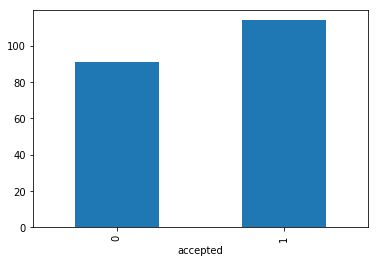

In [0]:
# mean income of people for which the loan has been approved vs the mean income of people for which the loan has not been approved
data_plot.groupby('accepted')['applicant_income'].mean().plot.bar()

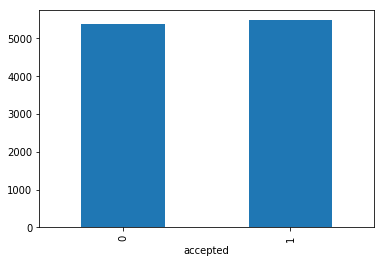

In [0]:
data_plot.groupby('accepted')['population'].mean().plot.bar()

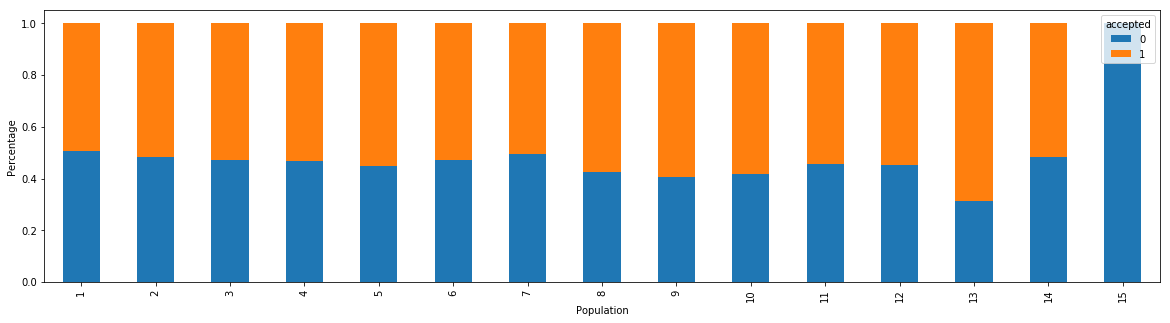

In [0]:
bins=[0,2500,5000,7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000] 
group=['1','2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'] 
data_plot['population_bin']=pd.cut(data_plot['population'],bins,labels=group)
population_bin=pd.crosstab(data_plot['population_bin'],data_plot['accepted']) 
population_bin.div(population_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(20,5)) 
plt.xlabel('Population') 
P = plt.ylabel('Percentage')

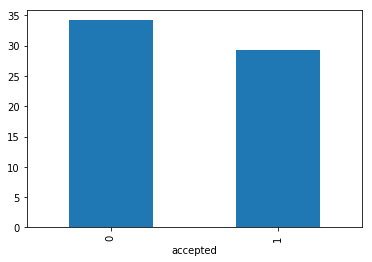

In [0]:
data_plot.groupby('accepted')['minority_population_pct'].mean().plot.bar()

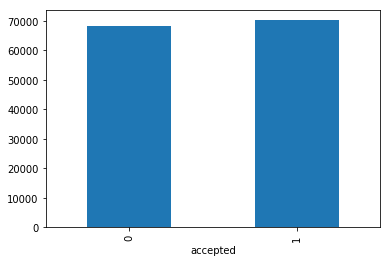

In [0]:
data_plot.groupby('accepted')['ffiecmedian_family_income'].mean().plot.bar()

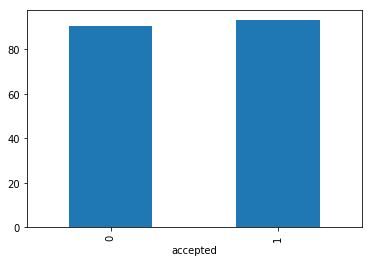

In [0]:
data_plot.groupby('accepted')['tract_to_msa_md_income_pct'].mean().plot.bar()

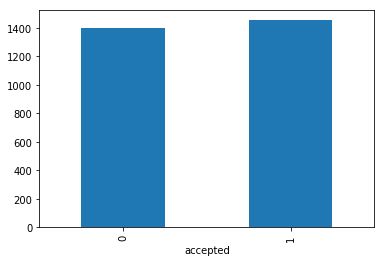

In [0]:
data_plot.groupby('accepted')['number_of_owner-occupied_units'].mean().plot.bar()

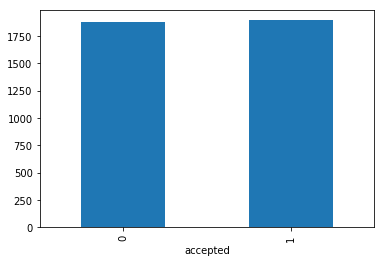

In [0]:
data_plot.groupby('accepted')['number_of_1_to_4_family_units'].mean().plot.bar()

## Handling missing values

### Why missing values treatment is required?
Missing data in the training data set can reduce the power/fit of a model or can lead to a biased model because we have not analysed the behavior and relationship with other variables correctly. It can lead to wrong prediction or classification.

Mean/Mode/Median imputation is one of the most frequently used methods. It consists of replacing the missing data for a given attribute by the mean or median (quantitative attribute) or mode (qualitative attribute) of all known values of that variable. It can be of two types:-
Generalized Imputation: In this case, we calculate the mean or median for all non missing values of that variable then replace missing value with mean or median. Like in above table, variable “Manpower” is missing so we take average of all non missing values of “Manpower”  (28.33) and then replace missing value with it.

In [0]:
data.isna().sum()

row_id                                0
loan_type                             0
property_type                         0
loan_purpose                          0
occupancy                             0
loan_amount                           0
preapproval                           0
state_code                            0
county_code                           0
applicant_ethnicity                   0
applicant_race                        0
applicant_sex                         0
applicant_income                  80089
population                        44945
minority_population_pct           44948
ffiecmedian_family_income         44893
tract_to_msa_md_income_pct        45031
number_of_owner-occupied_units    45139
number_of_1_to_4_family_units     45080
co_applicant                          0
sep                                   0
dtype: int64

## Handling categorical variables

For categorical variables, mode imputation was used

In [0]:
data.state_code = data.state_code.replace(-1, data.state_code.mode().values[0]).astype("int64")
data.county_code = data.county_code.replace(-1, 20).astype("int64")
data.occupancy = data.occupancy.replace(3, data.occupancy.mode().values[0]).astype("int64")
data.preapproval = data.preapproval.replace(3, 2).astype("int64")
data.applicant_ethnicity = data.applicant_ethnicity.replace(4, data.applicant_ethnicity.mode().values[0]).astype("int64")
data.applicant_sex = data.applicant_sex.replace(3, data.applicant_sex.mode().values[0]).astype("int64")
data.applicant_sex = data.applicant_sex.replace(4, data.applicant_sex.mode().values[0]).astype("int64")
data = data.drop(['applicant_race'],axis=1)

## Handling numerical variables

For numerical variables, median imputation was used. Mean was not used due to its sensitivity to outliers

In [0]:
#to fill the missing numeric variables by mean
data.applicant_income = data.applicant_income.fillna(data.applicant_income.mean())
data.population = data.population.fillna(data.population.mean())
data.minority_population_pct = data.minority_population_pct.fillna(data.minority_population_pct.mean())
data.ffiecmedian_family_income = data.ffiecmedian_family_income.fillna(data.ffiecmedian_family_income.mean())
data.tract_to_msa_md_income_pct = data.tract_to_msa_md_income_pct.fillna(data.tract_to_msa_md_income_pct.mean())
data["number_of_owner-occupied_units"] = data["number_of_owner-occupied_units"].fillna(data["number_of_owner-occupied_units"].mean())
data.number_of_1_to_4_family_units = data.number_of_1_to_4_family_units.fillna(data.number_of_1_to_4_family_units.mean())

Check whether there are still missing values

In [0]:
data.apply(lambda x: sum(x.isnull()),axis=0)

row_id                            0
loan_type                         0
property_type                     0
loan_purpose                      0
occupancy                         0
loan_amount                       0
preapproval                       0
state_code                        0
county_code                       0
applicant_ethnicity               0
applicant_sex                     0
applicant_income                  0
population                        0
minority_population_pct           0
ffiecmedian_family_income         0
tract_to_msa_md_income_pct        0
number_of_owner-occupied_units    0
number_of_1_to_4_family_units     0
co_applicant                      0
sep                               0
dtype: int64

## Feature Engineering

### What is Feature Engineering?
Feature engineering is the science (and art) of extracting more information from existing data. You are not adding any new data here, but you are actually making the data you already have more useful.

For example, let’s say you are trying to predict foot fall in a shopping mall based on dates. If you try and use the dates directly, you may not be able to extract meaningful insights from the data. This is because the foot fall is less affected by the day of the month than it is by the day of the week. Now this information about day of week is implicit in your data. You need to bring it out to make your model better.

In [0]:
data["co_applicant"] = data["co_applicant"].map({True:1, False:0})
data.head()

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,state_code,county_code,applicant_ethnicity,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,co_applicant,sep
0,0,3,1,1,1,70.0,2,37,246,2,1,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,0,Train
1,1,1,1,3,1,178.0,2,52,299,1,1,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,0,Train
2,2,2,1,3,1,163.0,2,10,306,2,1,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,0,Train
3,3,1,1,1,1,155.0,1,47,180,2,1,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,1,Train
4,4,1,1,1,1,305.0,2,37,20,2,2,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,0,Train


## Get dummy variable

In [0]:
# identifying categorical features
categorical_features = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'preapproval', 'applicant_ethnicity', 'applicant_sex', 'co_applicant']
print(categorical_features)

['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'preapproval', 'applicant_ethnicity', 'applicant_sex', 'co_applicant']


In [0]:
data = pd.get_dummies(data, columns = [x for x in categorical_features])

In [0]:
train = data[data.sep == "Train"]
test = data[data.sep == "Test"]
train = train.drop(['sep'],axis=1)
test = test.drop(['sep'],axis=1)
print(len(train), len(test))

500000 500000


In [0]:
train = pd.merge(train, train_labels, on='row_id')
train.head()

,row_id,loan_amount,state_code,county_code,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,loan_type_1,loan_type_2,loan_type_3,loan_type_4,property_type_1,property_type_2,property_type_3,loan_purpose_1,loan_purpose_2,loan_purpose_3,occupancy_1,occupancy_2,preapproval_1,preapproval_2,applicant_ethnicity_1,applicant_ethnicity_2,applicant_ethnicity_3,applicant_sex_1,applicant_sex_2,co_applicant_0,co_applicant_1,accepted
0,0,70.0,37,246,24.0,6203.0,44.230,60588.0,50.933,716.0,2642.0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1
1,1,178.0,52,299,57.0,5774.0,15.905,54821.0,100.000,1622.0,2108.0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,0
2,2,163.0,10,306,67.0,6094.0,61.270,67719.0,100.000,760.0,1048.0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1
3,3,155.0,47,180,105.0,6667.0,6.246,78439.0,100.000,2025.0,2299.0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,1
4,4,305.0,37,20,71.0,6732.0,100.000,63075.0,82.200,1464.0,1847.0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1


## Statistical Modeling

Our primary strategy when modeling this problem was to try different types of models and then potentially combine them. After much tinkering, 4 main models were selected and then combined them into a voting classifier. These models were an XGBoost, Gradient Boost, Adaboost and Random Forest classifiers.

As each model was built, it was evaluated with stratified k-fold cross validation over a training set and then evaluated on a validation set with the classification rate to best match the evaluator on the leaderboard.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn import ensemble

In [0]:
train.columns

Index(['row_id', 'loan_amount', 'state_code', 'county_code',
       'applicant_income', 'population', 'minority_population_pct',
       'ffiecmedian_family_income', 'tract_to_msa_md_income_pct',
       'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
       'loan_type_1', 'loan_type_2', 'loan_type_3', 'loan_type_4',
       'property_type_1', 'property_type_2', 'property_type_3',
       'loan_purpose_1', 'loan_purpose_2', 'loan_purpose_3', 'occupancy_1',
       'occupancy_2', 'preapproval_1', 'preapproval_2',
       'applicant_ethnicity_1', 'applicant_ethnicity_2',
       'applicant_ethnicity_3', 'applicant_sex_1', 'applicant_sex_2',
       'co_applicant_0', 'co_applicant_1', 'accepted'],
      dtype='object')

In [0]:
importantcols = [x for x in train.columns if x not in ['accepted', 'row_id']]
y = train[["accepted"]]
X = train[importantcols]

In [0]:
#Split the dataset into train and Test
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

## Models

### XGBoost

In [0]:
i=1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True) 
for train_index,test_index in kf.split(X,y):     
  print('\n{} of kfold {}'.format(i,kf.n_splits))     
  xtr,xvl = X.loc[train_index],X.loc[test_index]     
  ytr,yvl = y.loc[train_index],y.loc[test_index]         
  model = xgb.XGBClassifier(n_estimators=2000, max_depth=4)     
  model.fit(xtr, ytr)     
  pred_test = model.predict(xvl)     
  score = accuracy_score(yvl,pred_test)     
  print('accuracy_score',score)     
  i+=1 
# pred_test = model.predict(test) 
# pred3=model.predict_proba(test)[:,1]


1 of kfold 5


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy_score 0.6809331906680933

2 of kfold 5


In [0]:
#Train the XGboost Model for Classification
clf1 = xgb.XGBClassifier(n_estimators= 300)

model = clf1.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#prediction and Classification Report
pred = model.predict(X_test)
print('Model Report %r' % (classification_report(y_test, pred)))

Model Report '              precision    recall  f1-score   support\n\n           0       0.69      0.63      0.66     75044\n           1       0.66      0.71      0.69     74956\n\n    accuracy                           0.67    150000\n   macro avg       0.67      0.67      0.67    150000\nweighted avg       0.67      0.67      0.67    150000\n'


In [0]:
#Let's use accuracy score
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred) * 100))

Accuracy for model: 67.31


### Gradient Boost

In [0]:
# Fit regression model
params = {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 4,
          'learning_rate': 0.01}
clf = ensemble.GradientBoostingClassifier(**params)

model = clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#prediction and Classification Report
pred = model.predict(X_test)
print('Model Report %r' % (classification_report(y_test, pred)))

Model Report '              precision    recall  f1-score   support\n\n           0       0.68      0.63      0.65     75044\n           1       0.65      0.70      0.67     74956\n\n    accuracy                           0.66    150000\n   macro avg       0.66      0.66      0.66    150000\nweighted avg       0.66      0.66      0.66    150000\n'


In [0]:
#Let's use accuracy score
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred) * 100))

Accuracy for model: 66.42


### Adaboost

In [0]:
clf3 = AdaBoostClassifier(n_estimators=300)

model = clf3.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#prediction and Classification Report
pred = model.predict(X_test)
print('Model Report %r' % (classification_report(y_test, pred)))

Model Report '              precision    recall  f1-score   support\n\n           0       0.67      0.62      0.65     75044\n           1       0.65      0.69      0.67     74956\n\n    accuracy                           0.66    150000\n   macro avg       0.66      0.66      0.66    150000\nweighted avg       0.66      0.66      0.66    150000\n'


In [0]:
#Let's use accuracy score
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred) * 100))

Accuracy for model: 65.92


### Random Forest

In [0]:
clf4 = RandomForestClassifier(n_estimators=300, random_state=1)

model = clf4.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#prediction and Classification Report
pred = model.predict(X_test)
print('Model Report %r' % (classification_report(y_test, pred)))

Model Report '              precision    recall  f1-score   support\n\n           0       0.68      0.64      0.66     75044\n           1       0.66      0.70      0.68     74956\n\n    accuracy                           0.67    150000\n   macro avg       0.67      0.67      0.67    150000\nweighted avg       0.67      0.67      0.67    150000\n'


In [0]:
#Let's use accuracy score
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred) * 100))

Accuracy for model: 67.13


### Voting Classifier Ensemble

All 4 models where ensembled using a voting classifier, which is a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting

In [0]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('xgb', clf1), ('gbc', clf2), ('abc', clf3), ('rfc', clf4)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['XGBoost', 'Gradient Boost', 'Adaboost', 'Random Forest', 'Ensemble']):
  scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [0]:
model = eclf.fit(X_train, y_train)

In [0]:
#prediction and Classification Report
pred = model.predict(X_test)
print('Model Report %r' % (classification_report(y_test, pred)))

In [0]:
#Let's use accuracy score
print("Accuracy for model: %.2f" % (accuracy_score(y_test, pred) * 100))

## Conclusion

This data was sufficient for us to build a model with a classification rate of 0.7155, and while that's certainly better than a coin-flip our model is still quite uncertain in its predictions.

Thanks for your attention in going through this report!